In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt



In [120]:
# leo la imagen en escala de grises

img = cv.imread('C:/Users/c679529/Documents/GitHub/Computer_Vision1/Material_TPs/fft_alfa_pred.png', 0)
img.dtype

dtype('uint8')

In [92]:
#Creo una funcion que devuelve un filtro Gaussiano y un filtro Gaussiano transformado por fourier 2d

def create_gauss_filter(h, w, k_size=5, sigma=5):
    """
    Crea un filtro gaussiano de tamaño h x w.

    Args:
        h (int): Altura del filtro.
        w (int): Ancho del filtro.
        k_size (int): Tamaño del kernel gaussiano (por defecto: 5).
        sigma (int): Valor de sigma para el kernel gaussiano (por defecto: 5).
        

    Returns:
        np.ndarray: Filtro gaussiano de tamaño h x w.
        
    """
    kernel = cv.getGaussianKernel(k_size, sigma)
    gauss_filter = np.outer(kernel, kernel.T)
    
    pad = (w-k_size)//2
    crop = (h-k_size)//2
    
    if h % 2 == 0:
        par_h = 1
    else:
        par_h = 0

    if w % 2 == 0:
        par_w = 1
    else:
        par_w = 0

  
    # Realizar un padding y completamos con 0
    gauss_filter = np.pad(gauss_filter,pad_width=((crop,crop+par_h),(pad,pad+par_w)), mode='constant', constant_values=0)
    
    # Pasar el gaussiano por su transformada de furier 2D
    gaussian_fft = np.fft.fft2(gauss_filter)
    
    return gauss_filter,gaussian_fft
    

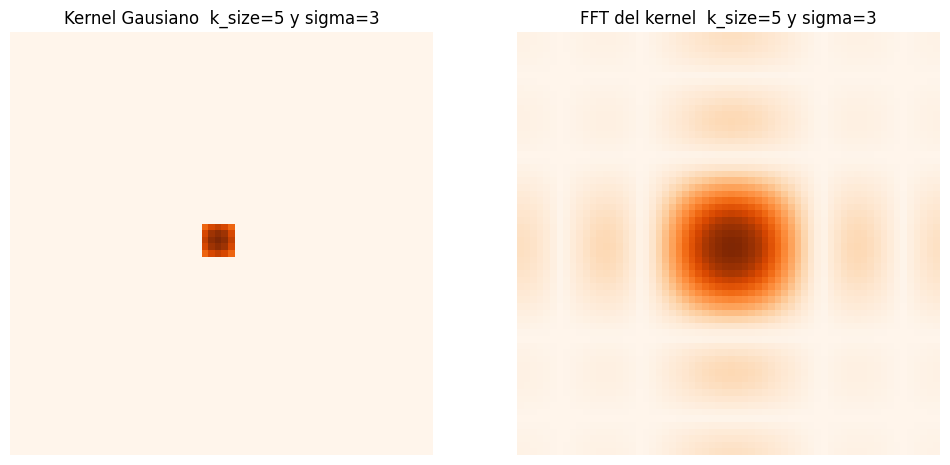

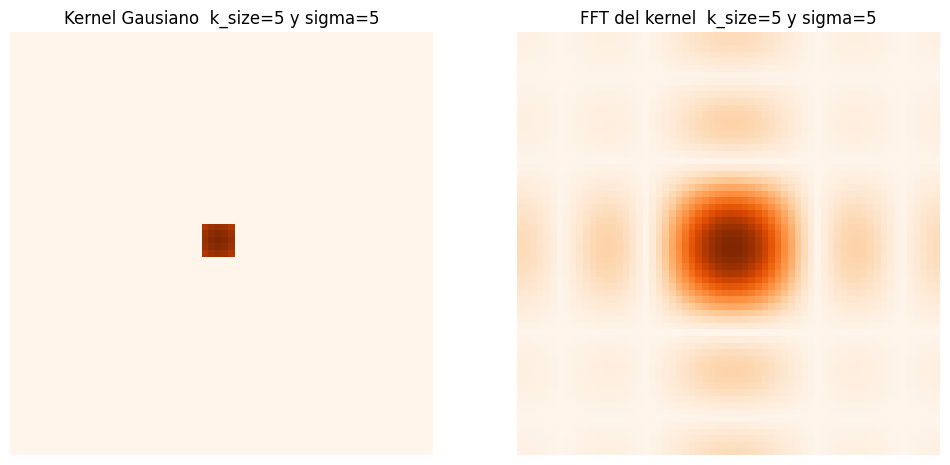

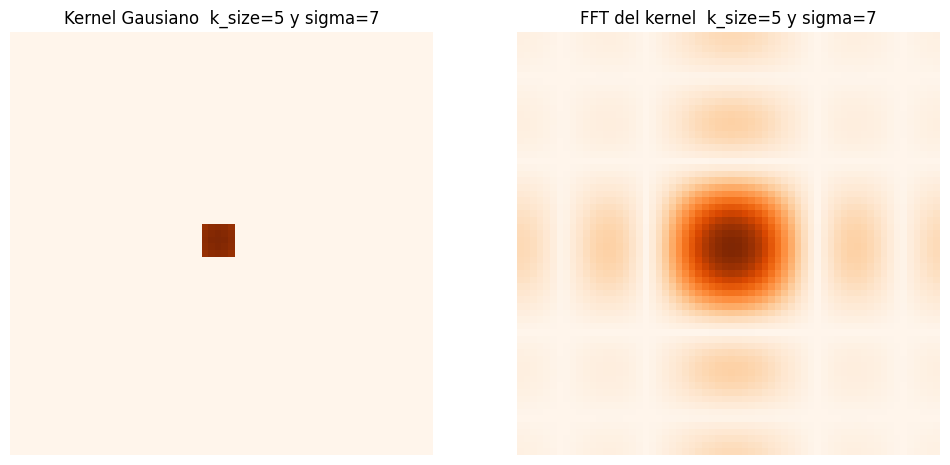

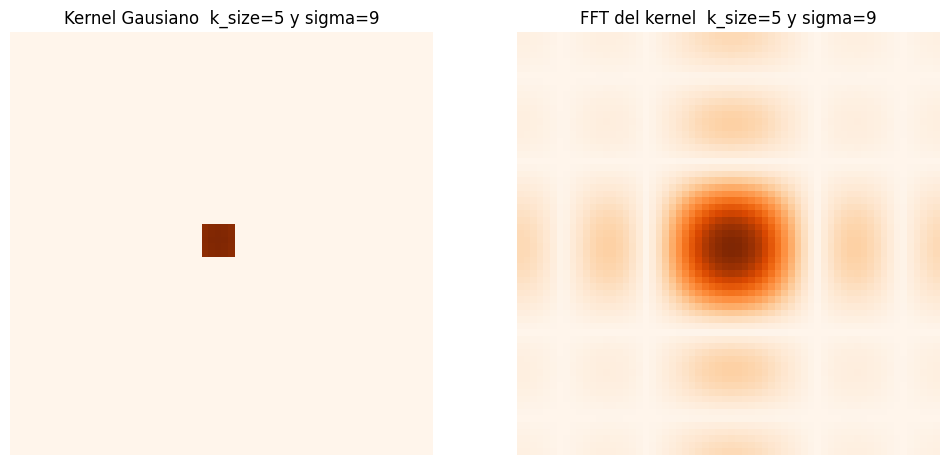

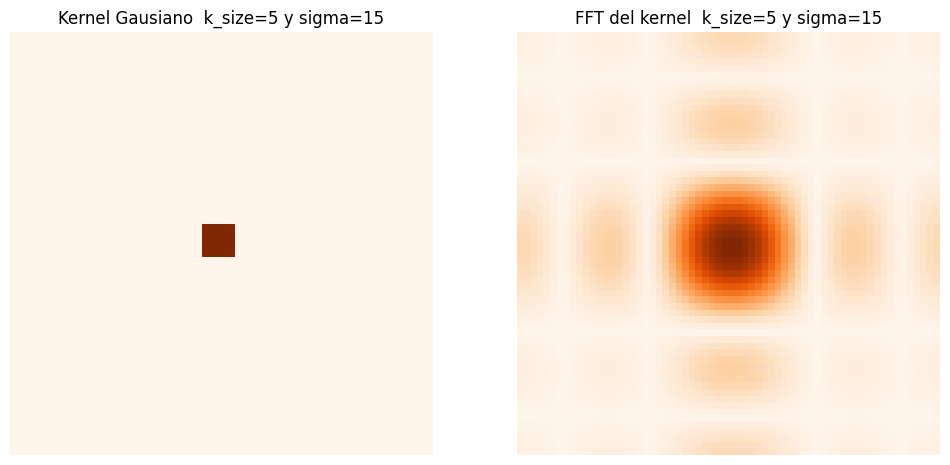

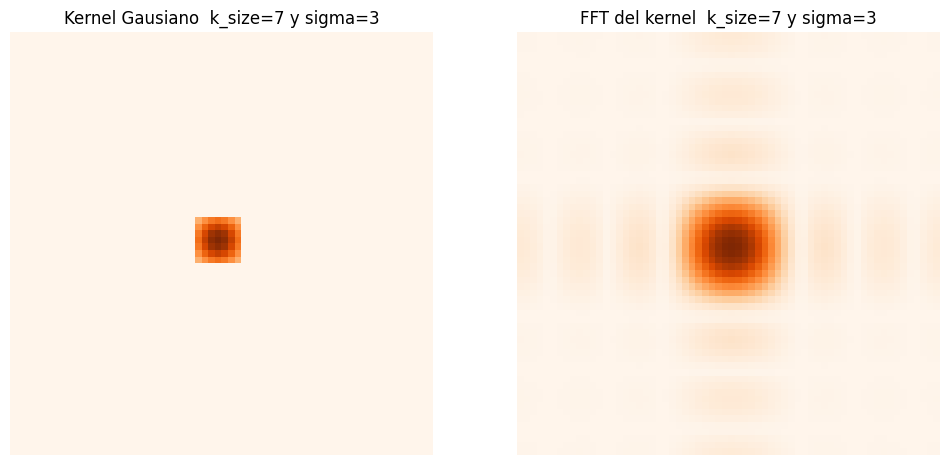

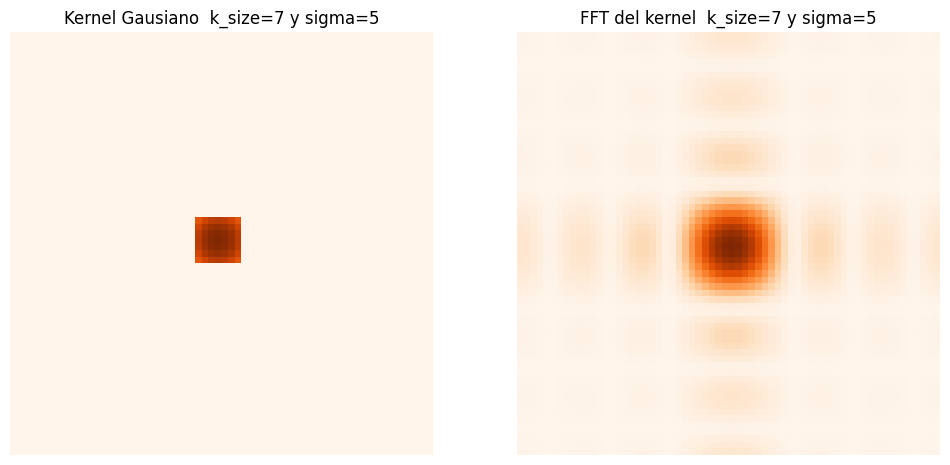

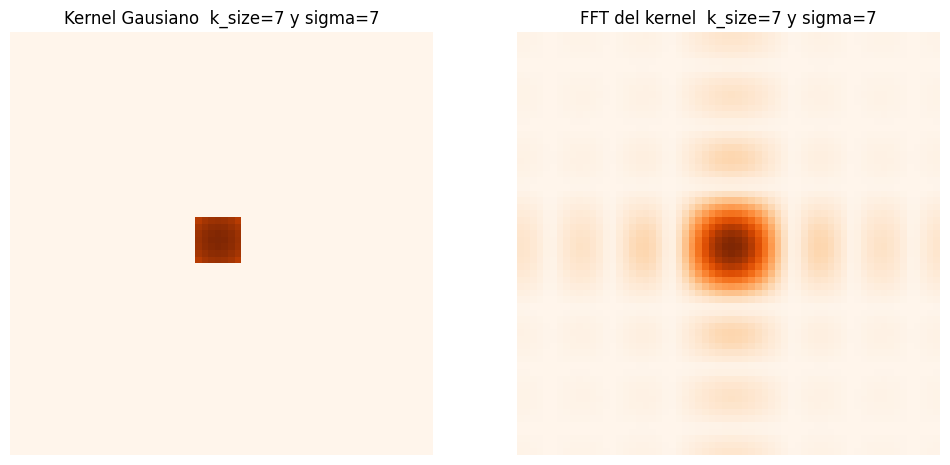

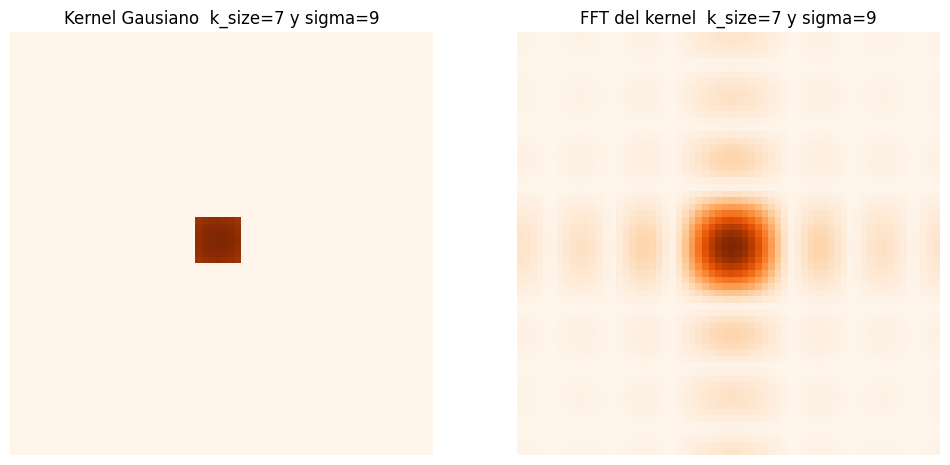

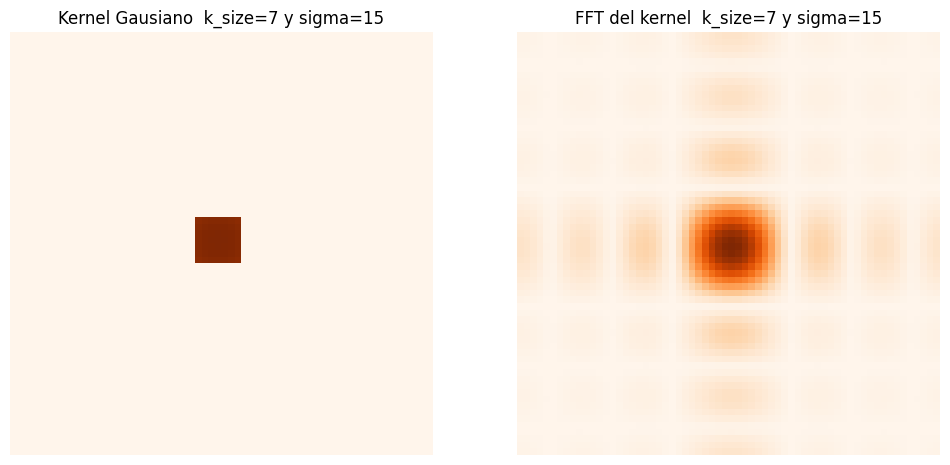

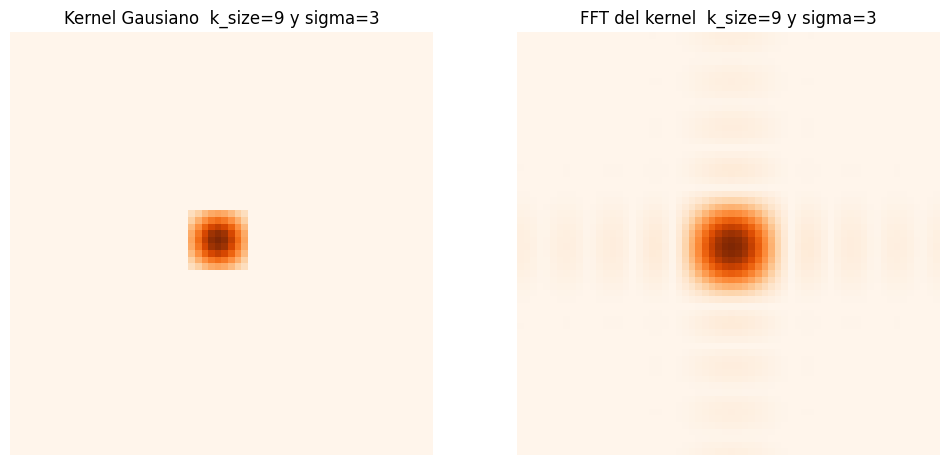

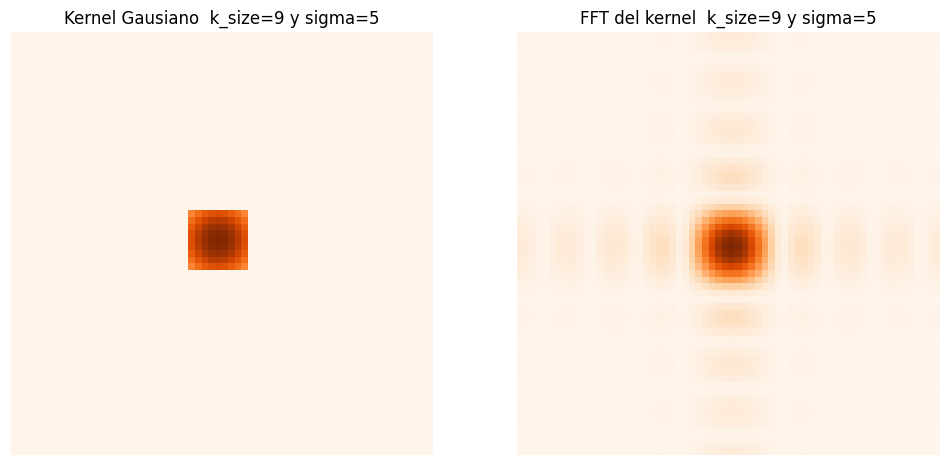

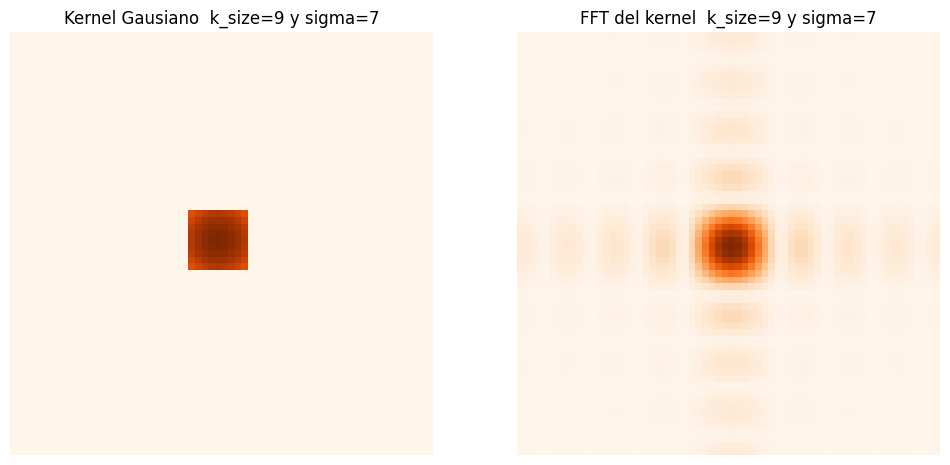

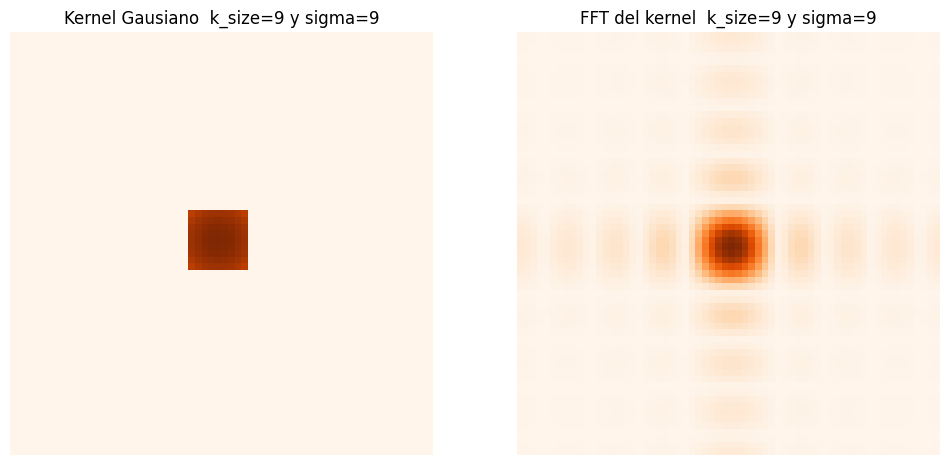

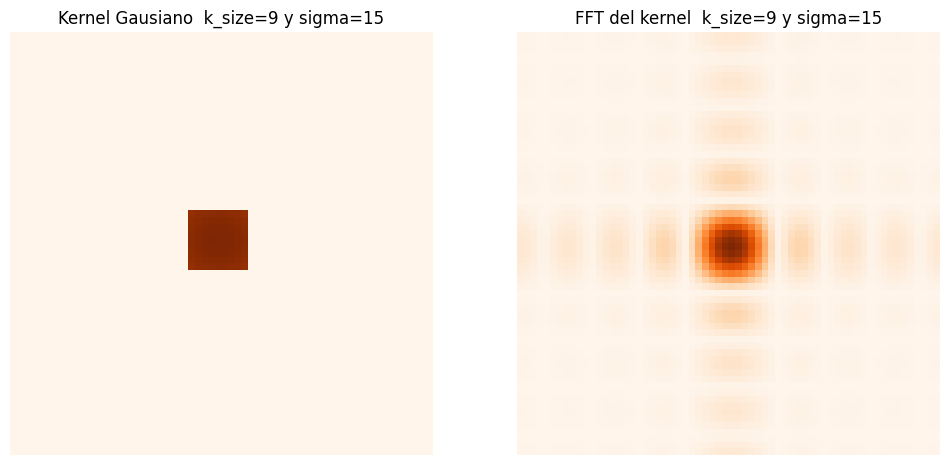

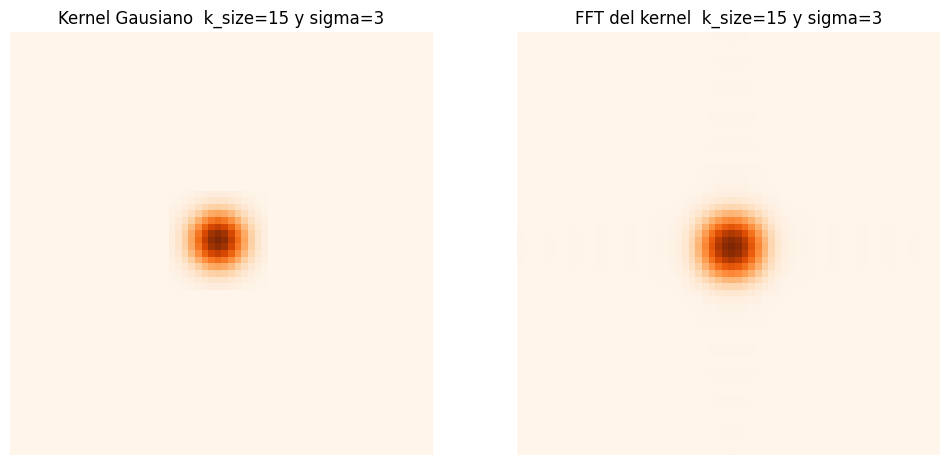

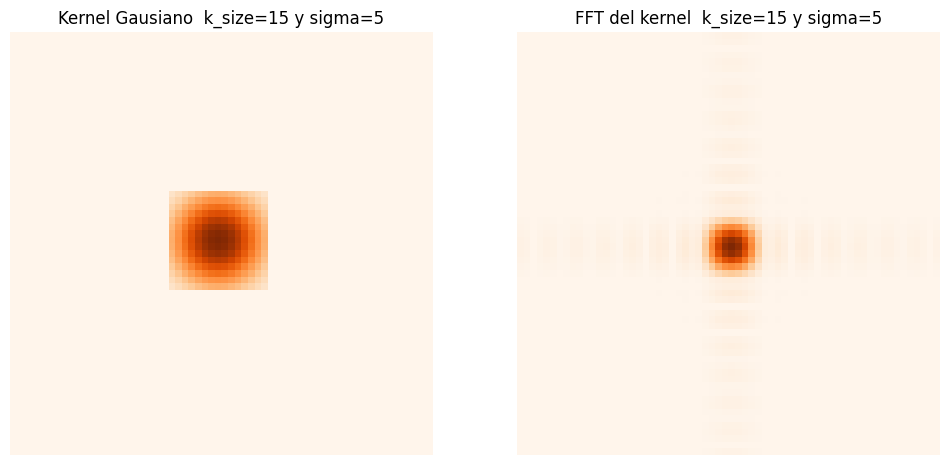

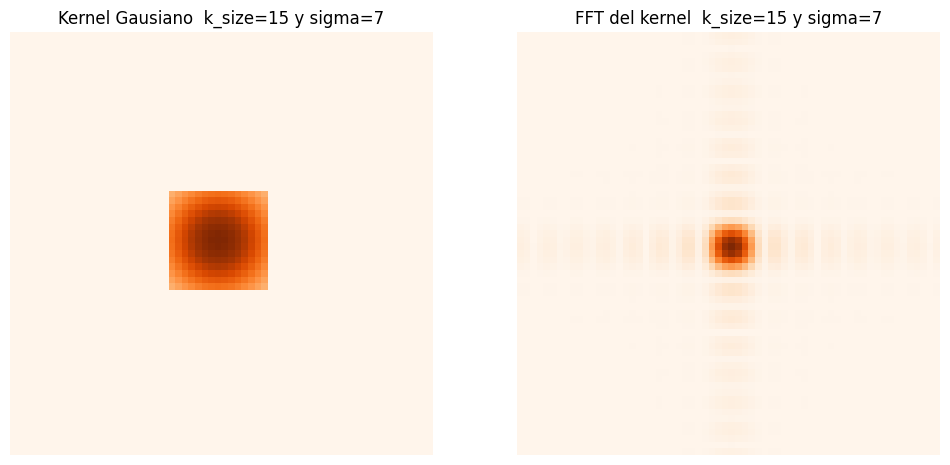

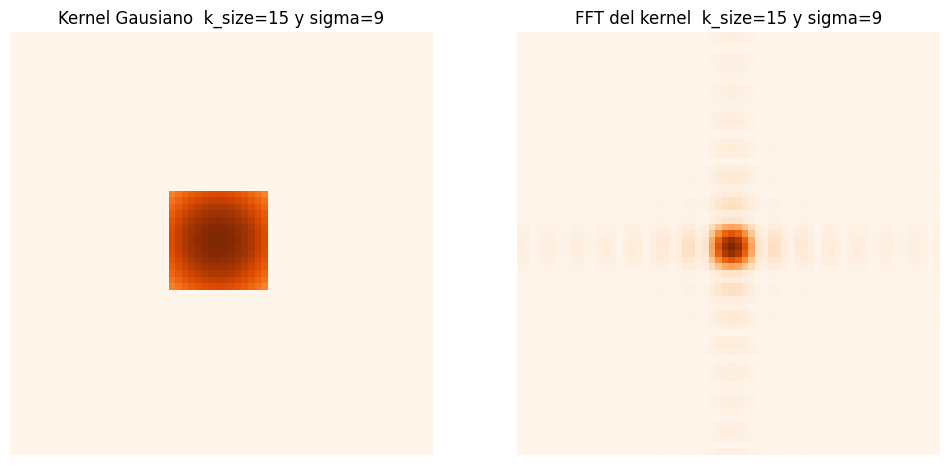

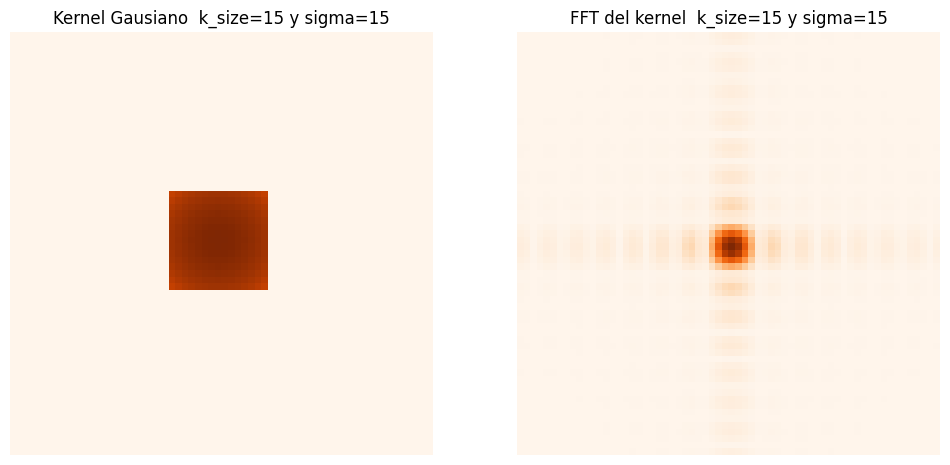

In [93]:
#Aplicamos distintos K-sizes y sigmas para probar los Filtros 
for kernels in [5, 7, 9, 15]:
    for Sigmas in [3, 5, 7, 9, 15]:
        kernel, kernel_tf = create_gauss_filter(h=64, w=64, k_size=kernels,sigma=Sigmas)

        plt.figure(figsize=(12,12))
        plt.subplot(1,2,1)
        plt.axis('off')
        plt.title(f"Kernel Gausiano  k_size={kernels} y sigma={Sigmas}")
        plt.imshow(kernel, cmap='Oranges')
        plt.subplot(1,2,2)
        plt.axis('off')
        plt.title(f"FFT del kernel  k_size={kernels} y sigma={Sigmas}")
        tf_shifted = np.fft.fftshift(kernel_tf)
        plt.imshow(np.abs(tf_shifted), cmap='Oranges');

Dimensiones de img_fft: (698, 341)
Dimensiones de kernel_tf: (64, 64)


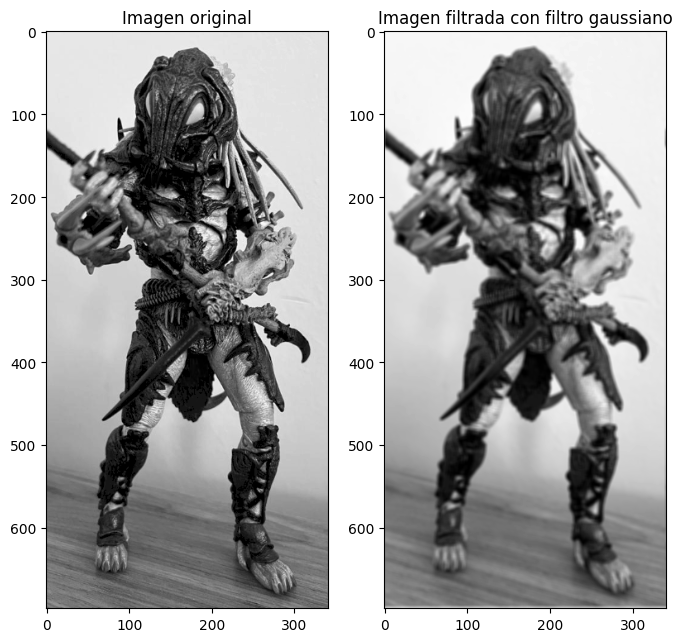

In [95]:
# Vamos a aplicar el Kernel Gaussiano y aplicar la antitransformada para volver a ver la imagen filtrada 
# Es mas sencillo aplicar matematicamente los filtros en el dominio espectral con una simple multiplicacion. 

#Tomemos las dimensiones del filtro segun las dimensiones de la imagen 

h,w = img.shape

# armamos los filtros apelando a la funcion , en este caso usamos los K y sigmas de default en 5

kernel, kernel_tff = create_gauss_filter(h, w)


# Defino la imagen en el dominio espectral

img_fft = np.fft.fft2(img)


print("Dimensiones de img_fft:", img_fft.shape)
print("Dimensiones de kernel_tf:", kernel_tf.shape)


# Aplico el kernel gaussiano transformado con la multiplicacion a la imagen espectral 
img_fft = img_fft * kernel_tff

# Aplicamos la antitransformada y obtenemos las imagenes filtradas
img_fft = np.fft.ifftshift(np.real(np.fft.ifft2(img_fft)))

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Imagen original')
plt.subplot(1,2,2)
plt.title('Imagen filtrada con filtro gaussiano')
plt.imshow(img_fft, cmap='gray')




In [96]:
#Armo la funcion del paper para medir la calidad de imagen 

def image_quality_measure(image):
    """""
    Args:
        image (np.ndarray): Input image of size M×N.

    Returns:
        float: Image Quality measure (FM).
        
    """
    # Step 1: Computar Transformada de fourier
    F = np.fft.fft2(image)

    # Step 2: Centro el origen
    Fc = np.fft.fftshift(F)

    # Step 3: Calculo el valor absoluto
    AF = np.abs(Fc)

    # Step 4: Calculo el maximo de frecuencia 
    M = np.max(AF)

    # Step 5: calculo el numero total de pixeles
    thres = M / 1000
    TH = np.sum(AF > thres)

    # Step 6: Calculo Image Quality measure (FM)
    FM = TH / (image.shape[0] * image.shape[1])

    return FM



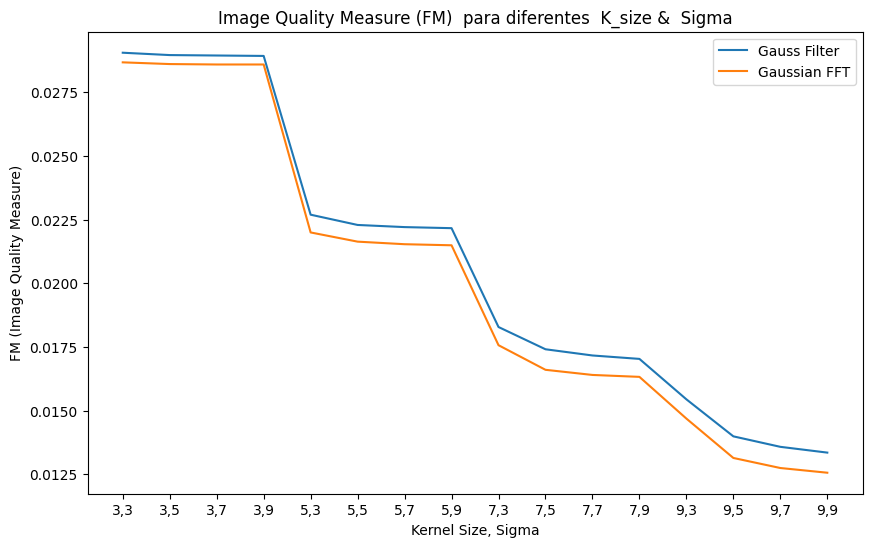

In [112]:
# Vamos a realizar un grafico para comparar la metrica de calidad de image para filtros Gaussianos y Gaussianos con transformada de Fourier

h, w = img.shape  # Tamaño de la imagen

# Valores a probar para k_size y sigma
k_sizes = [3, 5, 7, 9]
sigmas = [3,5,7,9]

# Lista para almacenar los resultados
results_gauss_filter = []
results_gaussian_fft = []


# Calcular FM para diferentes valores de k_size y sigma
for k_size in k_sizes:
    for sigma in sigmas:
        # Crear el filtro gaussiano y su transformada de Fourier
        gauss_filter, gaussian_fft = create_gauss_filter(h, w, k_size=k_size, sigma=sigma)
        
        # Aplicar los filtros a la imagen
        filtered_image_gauss_filter = cv.filter2D(img, -1, gauss_filter)
        img_fft = np.fft.fft2(img)
        img_fft = img_fft * gaussian_fft
        # Aplicamos la antitransformada y obtenemos las imagenes filtradas
        filtered_image_gaussian_fft = np.fft.ifftshift(np.real(np.fft.ifft2(img_fft)))
        
        # Calcular FM con las imágenes filtradas
        fm_gauss_filter = image_quality_measure(filtered_image_gauss_filter)
        fm_gaussian_fft = image_quality_measure(filtered_image_gaussian_fft)
        
        # Almacenar los resultados
        results_gauss_filter.append(fm_gauss_filter)
        results_gaussian_fft.append(fm_gaussian_fft)

# Crear el gráfico con dos líneas
plt.figure(figsize=(10, 6))
plt.plot(range(len(results_gauss_filter)), results_gauss_filter, label='Gauss Filter')
plt.plot(range(len(results_gaussian_fft)), results_gaussian_fft, label='Gaussian FFT')
plt.xticks(range(len(results_gauss_filter)), [f'{k},{s}' for k in k_sizes for s in sigmas])
plt.xlabel('Kernel Size, Sigma')
plt.ylabel('FM (Image Quality Measure)')
plt.title('Image Quality Measure (FM)  para diferentes  K_size &  Sigma')
plt.legend()
plt.show()


En este grafico se puede observar que la metrica de calidad de imagen da un mejor resultado en un filtro espectral que en un filtro espacial para los mismos tamaños de Kernel y Sigma



In [113]:
#Punto C)

#Calculo of grey level variance del paper “Analysis of focus measure operators in shape-from-focus"


def calculate_gray_level_variance(image):
    """
    Calculo el gray level variance de una imagen .

    Args:
        image (np.ndarray): Input image.

    Returns:
        float: Gray level variance.
    """
    # Flatten de imagen a un 1Darray
    flattened_image = image.flatten()

    # Calculo la media de la intensidad
    mean_intensity = np.mean(flattened_image)

    # Calculo el grey level variance 
    variance = np.mean((flattened_image - mean_intensity)**2)

    return variance




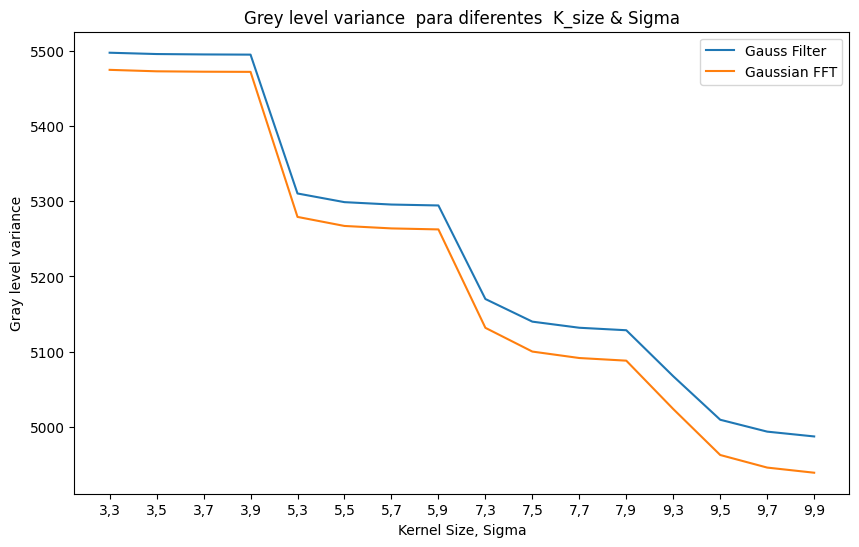

In [114]:
# Lista para almacenar los resultados
results_gauss_filter = []
results_gaussian_fft = []

# Calcular variance para diferentes valores de k_size y sigma
for k_size in k_sizes:
    for sigma in sigmas:
        # Crear el filtro gaussiano y su transformada de Fourier
        gauss_filter, gaussian_fft = create_gauss_filter(h, w, k_size=k_size, sigma=sigma)
        
        # Aplicar los filtros a la imagen
        filtered_image_gauss_filter = cv.filter2D(img, -1, gauss_filter)
        img_fft = np.fft.fft2(img)
        img_fft = img_fft * gaussian_fft
        # Aplicamos la antitransformada y obtenemos las imagenes filtradas
        filtered_image_gaussian_fft = np.fft.ifftshift(np.real(np.fft.ifft2(img_fft)))
        
        # Calcular FM con las imágenes filtradas
        fm_gauss_filter = calculate_gray_level_variance(filtered_image_gauss_filter)
        fm_gaussian_fft = calculate_gray_level_variance(filtered_image_gaussian_fft)
        
        # Almacenar los resultados
        results_gauss_filter.append(fm_gauss_filter)
        results_gaussian_fft.append(fm_gaussian_fft)

# Crear el gráfico con dos líneas
plt.figure(figsize=(10, 6))
plt.plot(range(len(results_gauss_filter)), results_gauss_filter, label='Gauss Filter')
plt.plot(range(len(results_gaussian_fft)), results_gaussian_fft, label='Gaussian FFT')
plt.xticks(range(len(results_gauss_filter)), [f'{k},{s}' for k in k_sizes for s in sigmas])
plt.xlabel('Kernel Size, Sigma')
plt.ylabel('Gray level variance')
plt.title('Grey level variance  para diferentes  K_size & Sigma')
plt.legend()
plt.show()
